In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

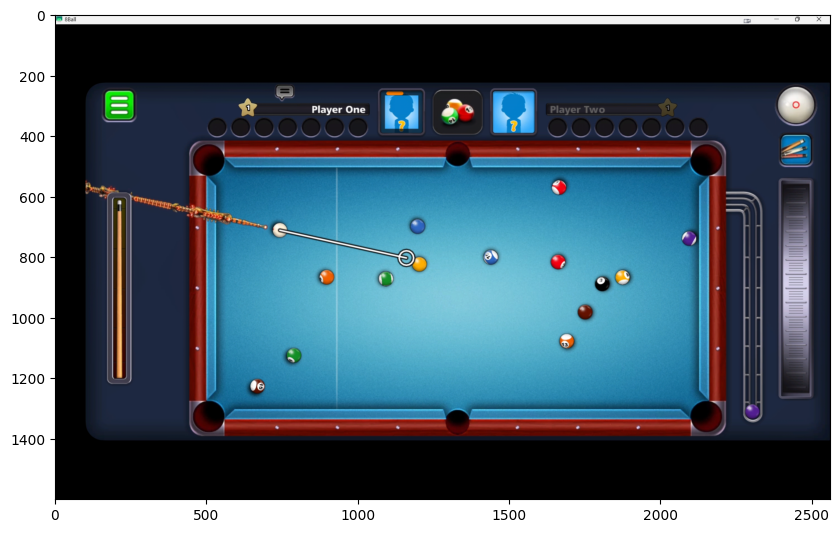

In [2]:
img = cv2.imread('screenshot.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# show image with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(img)

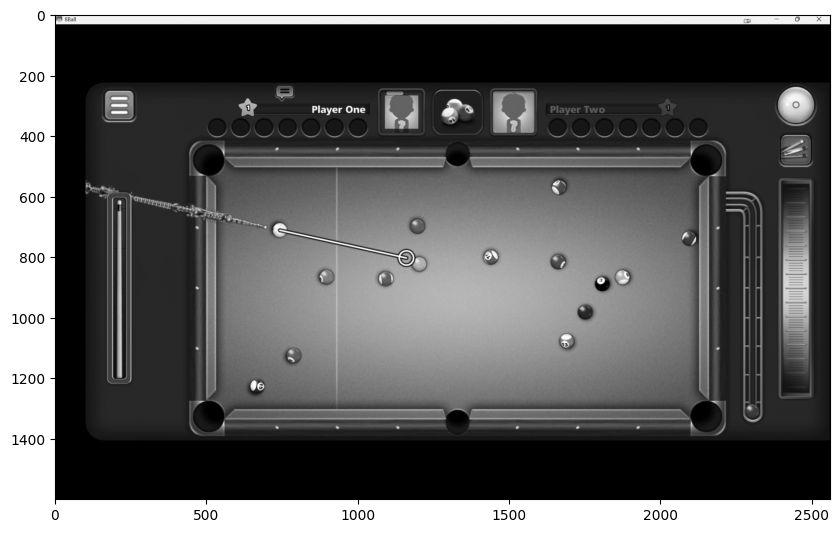

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# show image with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(gray, cmap='gray')

<Figure size 1000x1000 with 0 Axes>

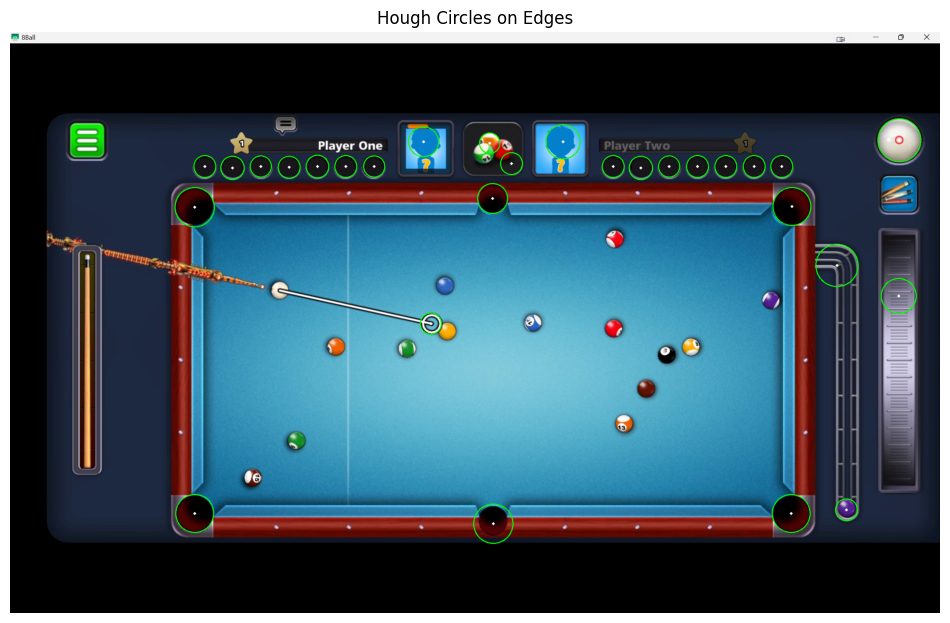

In [4]:
# Detect pockets
# edges = cv2.Canny(gray, 25, 75)

high_contrast = cv2.convertScaleAbs(gray, alpha=1.5, beta=0)
edges = cv2.GaussianBlur(high_contrast, (7, 7), 0)

plt.figure(figsize=(10, 10))
# plt.imshow(edges, cmap='gray')
# Hough Circle Transform with different parameters
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=50,
                          param1=70, param2=35, minRadius=28, maxRadius=60)

result = img.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw the outer circle
        cv2.circle(result, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Draw the center of the circle
        cv2.circle(result, (i[0], i[1]), 2, (255, 255, 255), 3)

# Convert to RGB for display
plt.figure(figsize=(12, 10))
plt.imshow(result)
plt.title('Hough Circles on Edges')
plt.axis('off')
plt.show()

In [9]:
# local original image and show
img = cv2.imread('screenshots/screenshot_5.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

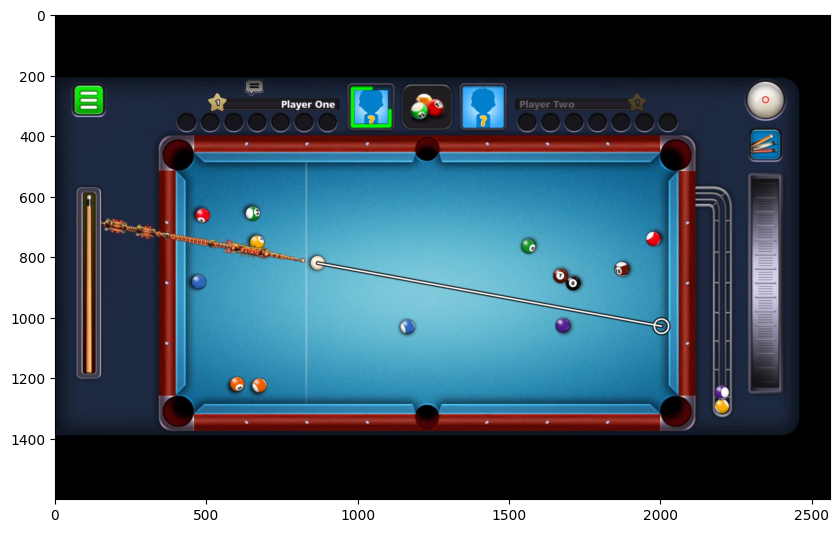

In [10]:
# show image
plt.figure(figsize=(10, 10))
plt.imshow(img)


In [ ]:
# figure out where the power cue stick is on the left